In [39]:
import pandas as pd
import os 
import seaborn as sns

In [35]:
# Seleccionar que años se van a tomar en cuenta, discutir esto
years = [str(i) for i in range(2010, 2024)]

datasets = []
for year in years:
    path = os.path.join("dataRaw", "atp_matches_" + year)
    dset = pd.read_csv(path + ".csv")
    datasets.append(dset)

In [36]:
df = pd.concat(datasets)
df = df.reset_index(drop = True)
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39490,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,NaN,4,D,20230204,5,202335,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717.0,1.0
39491,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,1,117365,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,990.0,11.0,279.0,190.0
39492,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,2,121411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,364.0,131.0,894.0,15.0
39493,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,4,144949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,894.0,15.0,285.0,184.0


In [37]:
# Selección de features
df.isnull().sum()/len(df)

tourney_id            0.000000
tourney_name          0.000000
surface               0.001342
draw_size             0.000000
tourney_level         0.000000
tourney_date          0.000000
match_num             0.000000
winner_id             0.000000
winner_seed           0.572807
winner_entry          0.868566
winner_name           0.000000
winner_hand           0.000177
winner_ht             0.019471
winner_ioc            0.000000
winner_age            0.000101
loser_id              0.000000
loser_seed            0.759843
loser_entry           0.786429
loser_name            0.000000
loser_hand            0.001063
loser_ht              0.039651
loser_ioc             0.000000
loser_age             0.000228
score                 0.000000
best_of               0.000000
round                 0.000000
minutes               0.104950
w_ace                 0.067907
w_df                  0.067907
w_svpt                0.067907
w_1stIn               0.067907
w_1stWon              0.067907
w_2ndWon

In [17]:
# Definir técnicas para rellenar datos, pero manteniendo una versión con datos clean.


In [21]:
# Viendo el año, podemos construir un set de testing, el siguiente número es el procentaje
# del tamaño del testing en comparación al total.

len(df[df["tourney_date"] >= 20180101])/len(df)

0.21997772518446332

In [23]:
# Generador del set de train/testing
date = 20180101 #yyyymmdd

train = df[df["tourney_date"] < date]
test = df[df["tourney_date"] >= date]

train.to_csv("train.csv")
test.to_csv("test.csv")

### Que hacer para el avance 

- Decidir un espacio de tiempo, junto a que features a utilizar y como tratar los datos faltantes. XXX
- Tratar features cualitativos. XXX
- Detección de features altamente correlacionados.
- Detección de outliers.
- Definición del set de testeo, por posible problema de dependencia temporal.
- Selección de modelos de clasificación a probar para predicción de resultados.

### Definir el dataset

- Se usará los partidos del 2000 a 2017 como training.
- Se usaran los datos de 2024 como validación.
- Se usará los partidos del 2018 a 2023 como testing.


In [44]:
# Features a usar

featuresNoEntrenables = ["winner_seed", "winner_entry", "loser_seed", "loser_entry"
                       "minutes", "round", "score", "tourney_id", "tourney_name"
                       "draw_size", "tourney_level", "tourney_date", "match_num",
                       "winner_name","loser_name"]

featuresDelMatch = ["surface", "winner_hand", "loser_hand", "winner_age",
                    "loser_age", "best_of"]

# best_of debe ser categorico

# featuresDeMatchPasados = #NUMERICOS


### No eliminar data, puesto que vamos a usar promedios.

<Axes: >

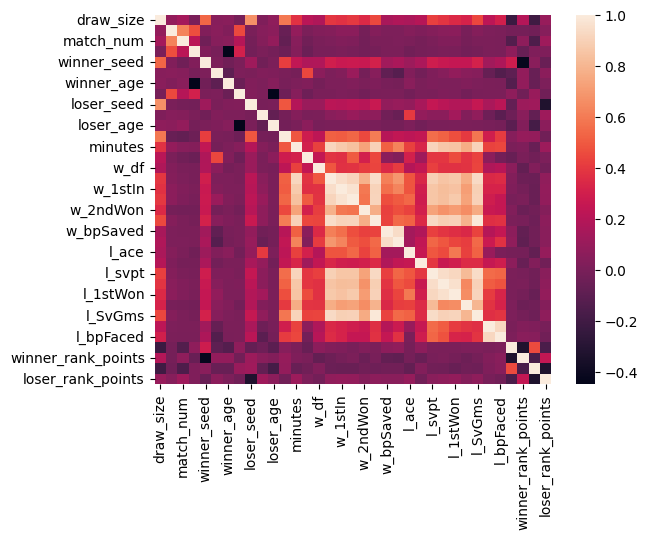

In [46]:
cuantitative_variables_names = df.select_dtypes(["float","int"]).columns.tolist()
df_corr = df[cuantitative_variables_names].corr()
sns.heatmap(df_corr, cmap = "rocket")